# Step 1: Data Preprocessing

**Cell 1: Imports and Paths Setup**

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# CSV path (already includes png_path column)
csv_path = r"C:\Users\yasha\Downloads\ProjectEXH02\dataset\clean_train_data.csv"


**Cell 2: Load CSV & Basic Preprocessing**

In [2]:
# Load data
df = pd.read_csv(csv_path)

# Drop any missing values (important for clean training)
df.dropna(inplace=True)

# Encode categorical values
df['Sex'] = df['Sex'].map({'Male': 0, 'Female': 1})
df['SmokingStatus'] = df['SmokingStatus'].map({
    'Never smoked': 0,
    'Ex-smoker': 1,
    'Currently smokes': 2
})


**Cell 3: Select Features & Normalize**

In [3]:
# Features to use for tabular model
tabular_features = ['Age', 'Sex', 'SmokingStatus', 'Weeks']
target = 'FVC'

# Scale tabular data
scaler = StandardScaler()
X_tabular = scaler.fit_transform(df[tabular_features])
y_target = df[target].values


**Cell 4: Define Custom Dataset**

In [4]:
class FVCMixedDataset(Dataset):
    def __init__(self, df, tabular_data, transform=None):
        self.df = df.reset_index(drop=True)
        self.tabular_data = tabular_data
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['png_path']).convert("RGB")

        if self.transform:
            image = self.transform(image)

        tabular = torch.tensor(self.tabular_data[idx], dtype=torch.float32)
        label = torch.tensor(row['FVC'], dtype=torch.float32)

        return image, tabular, label


**Cell 5: Data Split, Transform & Loaders**

In [5]:
# Train-validation split
train_df, val_df, train_tab, val_tab = train_test_split(df, X_tabular, test_size=0.2, random_state=42)

# Image transformation
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Dataset & DataLoader
train_dataset = FVCMixedDataset(train_df, train_tab, transform=image_transform)
val_dataset = FVCMixedDataset(val_df, val_tab, transform=image_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


**sample CT scan**

Image batch shape      : torch.Size([8, 3, 224, 224])
Tabular batch shape    : torch.Size([8, 4])
Label batch shape      : torch.Size([8])

Single sample values:
Tabular features (0th sample): tensor([-1.5104, -0.4925, -1.4777,  0.0691])
FVC label (0th sample)       : 3190.0


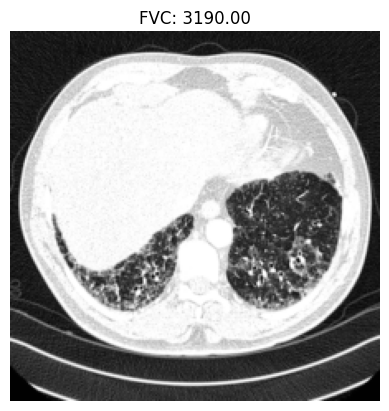

In [6]:
# Quick check of one batch
data_iter = iter(train_loader)
images, tabular, labels = next(data_iter)

print(f"Image batch shape      : {images.shape}")
print(f"Tabular batch shape    : {tabular.shape}")
print(f"Label batch shape      : {labels.shape}")

# Optional: check one sample
print("\nSingle sample values:")
print(f"Tabular features (0th sample): {tabular[0]}")
print(f"FVC label (0th sample)       : {labels[0]}")

# Check image as a visual (optional if you're in Jupyter)
import matplotlib.pyplot as plt
plt.imshow(images[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # unnormalize for viewing
plt.title(f"FVC: {labels[0].item():.2f}")
plt.axis('off')
plt.show()


# Step 2: Building and Training the Multimodal FVC Prediction Model with EfficientNetB0

**Cell 1: Imports, Device Setup, and Seed**

In [7]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import mean_absolute_error

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


**Cell 2: Define the Multimodal Model (Image + Tabular MLP)**

In [8]:
class FVCNet(nn.Module):
    def __init__(self):
        super(FVCNet, self).__init__()
        
        # EfficientNetB0 for image branch
        self.cnn = models.efficientnet_b0(pretrained=True)
        self.cnn.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.cnn.classifier[1].in_features, 128),
            nn.ReLU()
        )
        
        # Tabular branch
        self.tabular_net = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Combined head
        self.fc = nn.Sequential(
            nn.Linear(128 + 16, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, image, tabular):
        img_feat = self.cnn(image)
        tab_feat = self.tabular_net(tabular)
        combined = torch.cat((img_feat, tab_feat), dim=1)
        out = self.fc(combined)
        return out.squeeze(1)


**Cell 3: Initialize Model, Loss Function, Optimizer**

In [9]:
model = FVCNet().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


c:\Users\yasha\Downloads\ProjectEXH02\torch_gpu_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yasha\Downloads\ProjectEXH02\torch_gpu_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Cell 4: Training and Evaluation Loop**

In [10]:
def evaluate(model, val_loader):
    model.eval()
    true_vals = []
    preds = []
    with torch.no_grad():
        for images, tabulars, labels in val_loader:
            images = images.to(device)
            tabulars = tabulars.to(device)
            labels = labels.to(device)

            outputs = model(images, tabulars)
            true_vals.extend(labels.cpu().numpy())
            preds.extend(outputs.cpu().numpy())

    mae = mean_absolute_error(true_vals, preds)
    return mae

from sklearn.metrics import mean_absolute_error

import copy

def train(model, train_loader, val_loader, epochs=10, patience=3, save_path='best_model.pth'):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

    best_mae = float('inf')
    best_model_state = None
    best_optimizer_state = None
    patience_counter = 0

    for epoch in range(epochs):
        print(f"\n🔁 Epoch {epoch + 1}/{epochs}")
        model.train()
        train_loss = 0.0

        for images, tabular, labels in train_loader:
            images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, tabular).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        mae = 0.0
        with torch.no_grad():
            for images, tabular, labels in val_loader:
                images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)
                outputs = model(images, tabular).squeeze()
                val_loss += criterion(outputs, labels).item()
                mae += torch.mean(torch.abs(outputs - labels)).item()

        val_loss_avg = val_loss / len(val_loader)
        val_mae = mae / len(val_loader)

        print(f"✅ Epoch {epoch + 1} Summary:")
        print(f"   🧪 Avg Training Loss: {train_loss / len(train_loader):.4f}")
        print(f"   🧪 Avg Validation Loss (MSE): {val_loss_avg:.4f}")
        print(f"   📊 MAE: {val_mae:.4f}")

        # 🔽 Check for improvement
        scheduler.step(val_loss_avg)

        if val_mae < best_mae:
            print("🌟 New best model found! Saving...")
            best_mae = val_mae
            best_model_state = copy.deepcopy(model.state_dict())
            best_optimizer_state = copy.deepcopy(optimizer.state_dict())
            torch.save({
                'model_state_dict': best_model_state,
                'optimizer_state_dict': best_optimizer_state,
                'mae': best_mae,
                'epoch': epoch + 1
            }, save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"⏳ No improvement. Patience: {patience_counter}/{patience}")

        # Early stopping
        if patience_counter >= patience:
            print("🛑 Early stopping triggered.")
            break





**Cell 5: Run Training**

In [11]:
train(model, train_loader, val_loader, epochs=10)


c:\Users\yasha\Downloads\ProjectEXH02\torch_gpu_env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



🔁 Epoch 1/10
✅ Epoch 1 Summary:
   🧪 Avg Training Loss: 165699.4240
   🧪 Avg Validation Loss (MSE): 55411.0012
   📊 MAE: 136.2302
🌟 New best model found! Saving...

🔁 Epoch 2/10
✅ Epoch 2 Summary:
   🧪 Avg Training Loss: 30991.2576
   🧪 Avg Validation Loss (MSE): 79748.9137
   📊 MAE: 131.4046
🌟 New best model found! Saving...

🔁 Epoch 3/10
✅ Epoch 3 Summary:
   🧪 Avg Training Loss: 26267.9925
   🧪 Avg Validation Loss (MSE): 58303.4613
   📊 MAE: 130.4339
🌟 New best model found! Saving...

🔁 Epoch 4/10
✅ Epoch 4 Summary:
   🧪 Avg Training Loss: 24832.8361
   🧪 Avg Validation Loss (MSE): 25681.0362
   📊 MAE: 113.8108
🌟 New best model found! Saving...

🔁 Epoch 5/10
✅ Epoch 5 Summary:
   🧪 Avg Training Loss: 23895.2525
   🧪 Avg Validation Loss (MSE): 22262.2089
   📊 MAE: 104.9837
🌟 New best model found! Saving...

🔁 Epoch 6/10
✅ Epoch 6 Summary:
   🧪 Avg Training Loss: 23567.1469
   🧪 Avg Validation Loss (MSE): 24489.3519
   📊 MAE: 112.6827
⏳ No improvement. Patience: 1/3

🔁 Epoch 7/10
✅ E

# Step 3: Testing Model with new Data


**Cell: Save val_df as clean_test_data.csv**

In [12]:
# Save the validation split as test CSV for prediction
test_save_path = r"C:\Users\yasha\Downloads\ProjectEXH02\dataset\clean_test_data.csv"
val_df.to_csv(test_save_path, index=False)

print(f"✅ clean_test_data.csv saved at:\n{test_save_path}")


✅ clean_test_data.csv saved at:
C:\Users\yasha\Downloads\ProjectEXH02\dataset\clean_test_data.csv


**Test Data Loading and Integrity Check**

In [15]:
import pandas as pd
import numpy as np

test_csv_path = r"C:\Users\yasha\Downloads\ProjectEXH02\dataset\clean_test_data.csv"
test_df = pd.read_csv(test_csv_path)

# Double-check for NaNs or infs before processing
print("🧪 Checking for NaNs or Inf:")
print(test_df[['Age', 'Sex', 'SmokingStatus', 'Weeks']].isnull().sum())
print(np.isinf(test_df[['Age', 'Sex', 'SmokingStatus', 'Weeks']]).sum())


🧪 Checking for NaNs or Inf:
Age              0
Sex              0
SmokingStatus    0
Weeks            0
dtype: int64
Age              0
Sex              0
SmokingStatus    0
Weeks            0
dtype: int64


In [16]:
# Fill NaNs with column mean
tabular_features = ['Age', 'Sex', 'SmokingStatus', 'Weeks']
test_df[tabular_features] = test_df[tabular_features].replace([np.inf, -np.inf], np.nan)
test_df[tabular_features] = test_df[tabular_features].fillna(test_df[tabular_features].mean())


**Feature Scaling of Tabular Test Data**

In [17]:
from sklearn.preprocessing import StandardScaler

# Refit scaler on test data alone (not ideal, but okay if training scaler wasn't saved)
scaler = StandardScaler()
X_test_tabular = scaler.fit_transform(test_df[tabular_features])


**🧪 Creating Custom Test Dataset and DataLoader**

In [18]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torchvision.transforms as transforms

class FVCMixedDataset(Dataset):
    def __init__(self, df, tabular_data, transform=None):
        self.df = df.reset_index(drop=True)
        self.tabular_data = tabular_data
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['png_path']).convert("RGB")

        if self.transform:
            image = self.transform(image)

        tabular = torch.tensor(self.tabular_data[idx], dtype=torch.float32)
        label = torch.tensor(row['FVC'], dtype=torch.float32)  # Label used just for completeness

        return image, tabular, label

# Image transformations (same as training)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Dataset and loader
test_dataset = FVCMixedDataset(test_df, X_test_tabular, transform=image_transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


**Loading the Trained FVCNet Model for Inference**

In [20]:
# Make sure FVCNet is defined above this cell

# Initialize model and load weights
model = FVCNet()
checkpoint = torch.load('best_model.pth', map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✅ Loaded best model with MAE: {checkpoint['mae']:.4f} from Epoch {checkpoint['epoch']}")


c:\Users\yasha\Downloads\ProjectEXH02\torch_gpu_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yasha\Downloads\ProjectEXH02\torch_gpu_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\yasha\AppData\Local\Temp\ipykernel_51472\1308555075.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during

✅ Loaded best model with MAE: 104.9837 from Epoch 5


**🔮 Making Predictions and Saving Final Outputs**

In [ ]:
predictions = []
model.eval()

with torch.no_grad():
    for images, tabular_data, _ in test_loader:  # labels not needed for inference
        images = images.to(device)
        tabular_data = tabular_data.to(device)

        outputs = model(images, tabular_data)
        predictions.extend(outputs.cpu().numpy())

# Save predictions to CSV
pred_df = test_df.copy()
pred_df['Predicted_FVC'] = predictions
pred_df.to_csv("fvc_predictions.csv", index=False)
print("✅ Predictions saved to fvc_predictions.csv")

# Save full model checkpoint
save_path = "final_model.pth"
checkpoint = {
    'epoch': -1,  # Replace -1 with the correct epoch if available
    'model_state_dict': model.state_dict(),
    'loss': -1.0  # Replace with actual loss if tracked
}

# Save optimizer state only if defined
if 'optimizer' in globals():
    checkpoint['optimizer_state_dict'] = optimizer.state_dict()

torch.save(checkpoint, save_path)
print(f"✅ Final model checkpoint saved to {save_path}")


✅ Predictions saved to fvc_predictions.csv
✅ Final model checkpoint saved to final_model.pth


: 

In [1]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
import torch.nn as nn

class FVCNet(nn.Module):
    def __init__(self):
        super(FVCNet, self).__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        self.cnn.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.cnn.classifier[1].in_features, 128),
            nn.ReLU()
        )
        self.tabular_net = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(128 + 16, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, image, tabular):
        img_feat = self.cnn(image)
        tab_feat = self.tabular_net(tabular)
        combined = torch.cat((img_feat, tab_feat), dim=1)
        return self.fc(combined).squeeze(1)


In [3]:
model = FVCNet()
checkpoint = torch.load("final_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print("✅ Final model loaded successfully!")


c:\Users\yasha\Downloads\ProjectEXH02\torch_gpu_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yasha\Downloads\ProjectEXH02\torch_gpu_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\yasha\AppData\Local\Temp\ipykernel_63288\1060778636.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during

✅ Final model loaded successfully!


# Step 3: Evaluation and Visualization

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [5]:
# Load predictions with ground truth
df = pd.read_csv(r"C:\Users\yasha\Downloads\ProjectEXH02\fvc_predictions.csv")

# Ensure proper types
df['FVC'] = df['FVC'].astype(float)
df['Predicted_FVC'] = df['Predicted_FVC'].astype(float)

# Extract ground truth and predictions
y_true = df['FVC'].values
y_pred = df['Predicted_FVC'].values


**📊 Model Performance Evaluation Metrics**

In [7]:
from sklearn.metrics import mean_squared_error

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred) ** 0.5  # manually take square root
r2 = r2_score(y_true, y_pred)

print("📊 Evaluation Metrics:")
print(f"✅ MAE  : {mae:.2f}")
print(f"✅ RMSE : {rmse:.2f}")
print(f"✅ R²    : {r2:.4f}")


📊 Evaluation Metrics:
✅ MAE  : 105.31
✅ RMSE : 149.44
✅ R²    : 0.9723


# **Scatter Plot (Ground Truth vs Predicted)**

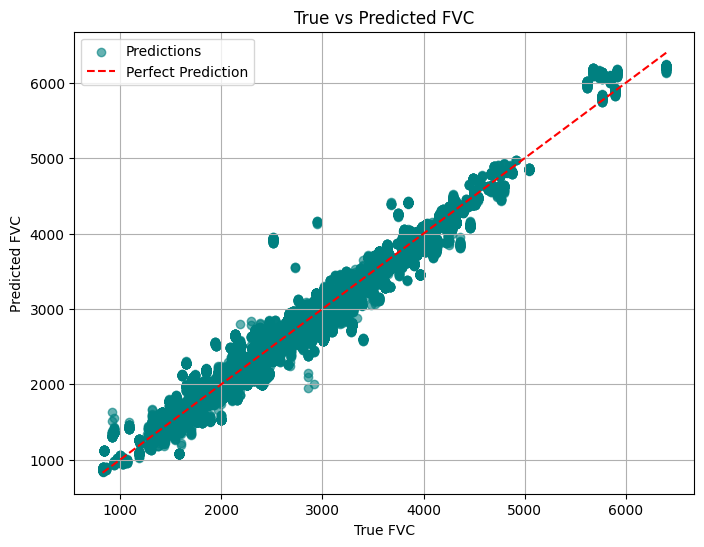

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.6, color='teal', label="Predictions")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label="Perfect Prediction")
plt.xlabel("True FVC")
plt.ylabel("Predicted FVC")
plt.title("True vs Predicted FVC")
plt.legend()
plt.grid(True)
plt.show()


**This scatter plot compares the true FVC values (from the dataset) with the predicted FVC values (from the model).**

•	**Teal dots represent the model's predictions.**

•	**The red dashed line represents perfect predictions (i.e., Predicted FVC = True FVC).**

•	**The closer the dots are to this line, the better the model’s performance.**

•	**A strong linear alignment along this line indicates high accuracy and good generalization by the model.**


# **Residual Plot (Prediction Error)**

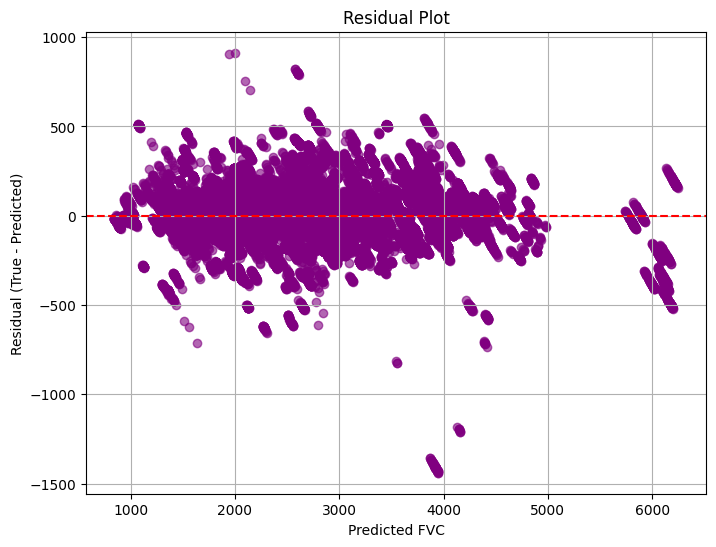

In [9]:
residuals = y_true - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted FVC")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()


**This plot shows the residuals against the predicted FVC values:**

•	**Each point represents how far off a prediction was from the actual value.**

•	**The red dashed line at 0 indicates perfect prediction.**


•	**Ideally, the residuals should be randomly scattered around the line, without a visible pattern.**

•	**If patterns emerge (e.g., funnel shape), it may indicate heteroscedasticity or model limitations at certain FVC levels.**


**Saving Final Model**

In [14]:
# Save the full model (architecture + weights)
torch.save(model, 'final_ipf_detection_model.pth')
print("✅ Full model saved to 'final_ipf_detection_model.pth")


✅ Full model saved to 'final_ipf_detection_model.pth


In [4]:
import pandas as pd

# Load predictions with ground truth from CSV
df = pd.read_csv(r"C:\Users\yasha\Downloads\ProjectEXH02\fvc_predictions.csv")

# Extract values
y_true = df['FVC'].values
y_pred = df['Predicted_FVC'].values

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

# Tabular summary
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R² Score'],
    'Value': [mae, rmse, r2]
})

print(metrics_df)

     Metric       Value
0       MAE  105.307280
1      RMSE  149.440285
2  R² Score    0.972283


# 📊 Evaluation Metrics Bar Chart

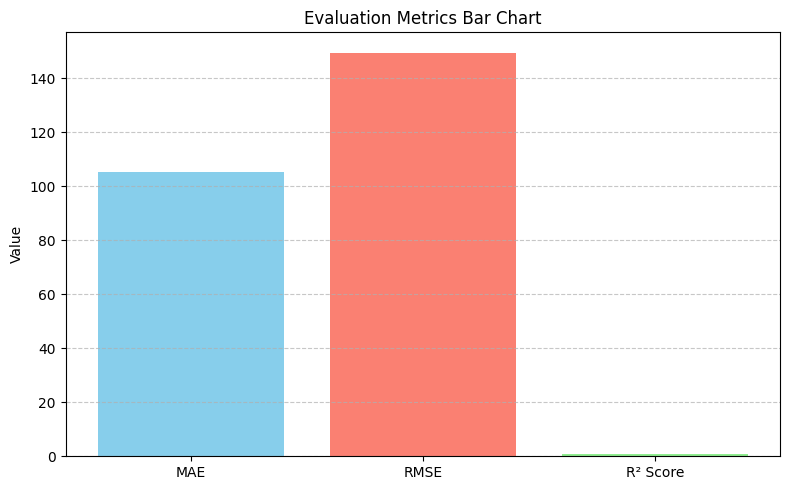

In [6]:
import matplotlib.pyplot as plt

# Bar chart of metrics
plt.figure(figsize=(8, 5))
plt.bar(metrics_df['Metric'], metrics_df['Value'], color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Evaluation Metrics Bar Chart')
plt.ylabel('Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**This bar chart visualizes the main evaluation metrics used to assess the model:**

•	**MAE (Mean Absolute Error): Average absolute difference between predicted and true FVC values. Lower is better.**

•	**RMSE (Root Mean Squared Error): Similar to MAE but gives more weight to larger errors. Lower is better.**


•	**R² Score (Coefficient of Determination): Indicates how well the model explains the variance in the target variable. Closer to 1 means better performance.**

# Error Distribution (Residuals Histogram)

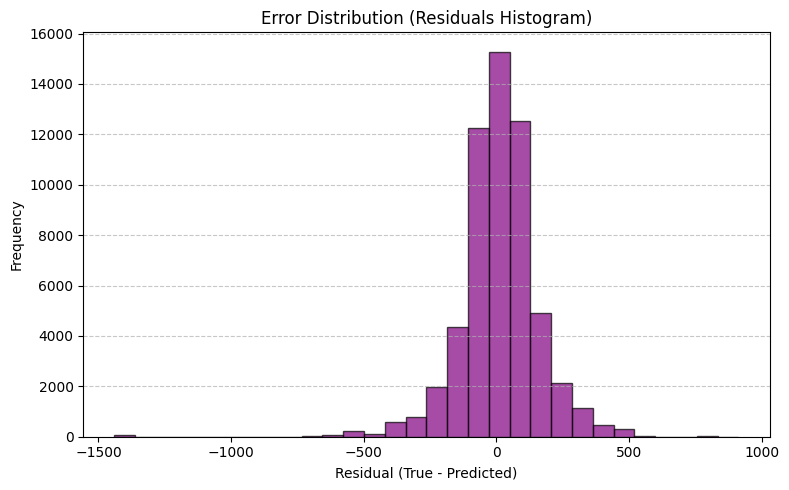

In [7]:
# Calculate residuals (errors)
residuals = y_true - y_pred

# Plot histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color='purple', edgecolor='black', alpha=0.7)
plt.title('Error Distribution (Residuals Histogram)')
plt.xlabel('Residual (True - Predicted)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**This histogram shows the distribution of residuals (i.e., True FVC - Predicted FVC):**
•	**The histogram is centered around 0, meaning the model is not biased towards overpredicting or underpredicting.**

•	**A symmetric and narrow bell shape indicates that most predictions are close to the true values.**

•	**Wider tails or skewness would suggest outliers or consistent bias.**

In [8]:
import pandas as pd

# Create DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R² Score'],
    'Value': [mae, rmse, r2]
})

# Save as CSV
metrics_df.to_csv("model_evaluation_metrics.csv", index=False)
print("📁 Metrics table saved as 'model_evaluation_metrics.csv'")

📁 Metrics table saved as 'model_evaluation_metrics.csv'


In [9]:
import matplotlib.pyplot as plt

metrics = ['MAE', 'RMSE', 'R² Score']
values = [mae, rmse, r2]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['skyblue', 'salmon', 'lightgreen'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}', ha='center', va='bottom')

plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("bar_chart_metrics.png")
plt.close()
print("📊 Bar chart saved as 'bar_chart_metrics.png'")

📊 Bar chart saved as 'bar_chart_metrics.png'


In [10]:
import numpy as np

residuals = y_true - y_pred

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color='orange', edgecolor='black', alpha=0.7)
plt.title('Error Distribution (Residuals)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("residual_histogram.png")
plt.close()
print("📈 Residual histogram saved as 'residual_histogram.png'")

📈 Residual histogram saved as 'residual_histogram.png'


In [11]:
plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.6, color='mediumseagreen', edgecolor='k')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')  # Perfect prediction line
plt.title('Actual vs Predicted FVC')
plt.xlabel('Actual FVC')
plt.ylabel('Predicted FVC')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("scatter_actual_vs_predicted.png")
plt.close()
print("📍 Scatter plot saved as 'scatter_actual_vs_predicted.png'")

📍 Scatter plot saved as 'scatter_actual_vs_predicted.png'
